# Simple DC-Motor Control
## Exporting the Model as a Functional Mockup Unit (FMU)
1. Import the export_fmu function from fmu_export

In [1]:
import os
import sys
sys.path.append(os.path.realpath('..//..')+ '/src')
from fmu_export import export_fmu

2. Define the model directory, model name and the modeling enviroment, "d" for Dymola (currently only dymola is supported). 

In [12]:
model_directory = os.path.realpath('.')
model_name = "DC_Motor"
modeling_environment = "d"

3. Import Parameters\
Parameters can be imported to the modeling environment in to different ways. /
 - Storing component data in a json file. The directory of the datasheet needs to be specified. The name of the json file and component name in the modelica model are stored in a dictionary. 
 ```Json
 // Example datasheet
{"Parameters":[{"symbol": "d",
                "value": 0.1,
                }, 
                {"symbol": "useHeatPort",
                "value": "false",
                }]}
    ```


In [13]:
datasheet_directory = os.path.realpath('.')
datasheets = {"damper" : "damper_datasheet"} #{component name : datasheet name}

- Storing the parameter name and the value in a dictionary. 

In [14]:
parameters = {"inertia.J" : 0.5} # {component_name.variable_symbol : value, ...}

3. Define the path to the Dymola executable.

In [15]:
dymola_path = "C:/Program Files/Dymola 2018 FD01/bin64"          

4. Define the output directory. 

In [16]:
output_directory = os.path.realpath('.')

5. The fmu export will output 3 files by default. The fmu, a log file and a run.mos file. If the log file or the run file is not needed, set keep_log and/or keep_run to false.

In [17]:
keep_run = False
keep_log = False

6. Export the fmu.

In [18]:
fmu = export_fmu(modeling_environment, model_name, model_directory,dymola_path, output_directory, datasheet_directory= datasheet_directory, datasheets= datasheets, additional_parameters= parameters, keep_run = keep_run, keep_log = keep_log)

The FMU Export was successful.


## Simulating
1. If the model should be simulated with a controller, the controller needs to be written in python. The controller should be a class and must contain the following methodes: set_input, generate_output, get_output. If a certain methode is not needed for the controller, just add a pass statement to the methode. 

2. Make connections between the fmu and the controller as follows. The information of the fmus and controller are stored in a list in case more than one fmu or controller need to be simulated. 

In [20]:
from discrete_pid import PID
fmu_path = os.path.join(os.path.realpath('.'), "DC_0Motor.fmu") # or get the fmu path by calling fmu.fmu_path

pid = PID(0.0001, 3,20, 0.1, set_point = 100, u_max= 100, u_min= 0) # initiate the controller

fmus = [{"model name": "DC_Motor", "path" : fmu_path,
"connections" :[{"input name": "u", "connect to system": "pid", "connect to variable": "u"}]}]

controllers = [{"control name": "pid", "control class" : pid, 
"connections" : [{"input name": "speed", "connect to system": "DC_Motor", "connect to variable": "y"}]}]

3. Define the variables for which the time series should be stored.

In [21]:
record = {"DC_Motor": ["y", "MotorTorque.tau"], "pid": ["u"]} # {"system name": [variable name, ...], ...}

4. Import the simulate function and simulate the model. If get_units is set to 'True', in addition to the simulation results, a dictionary with the units of the recorded variables is returned.

In [22]:
from simulate import simulate
stop_time = 10
step_size = 0.0001
results, units = simulate(stop_time, step_size, fmus, controllers, record, get_units= True)

FMU DC_0Motor.fmu initialized.
The class 'PID' contains all the necessary methods.
Starting Simulation...
Simulation completed.


## Plotting the results
For plotting, a simple plot function can be imported that returns an axis object so that the plot can be edited. Or simply create your own plot with matplotlib.

Text(0, 0.5, 'VOLTAGE in V')

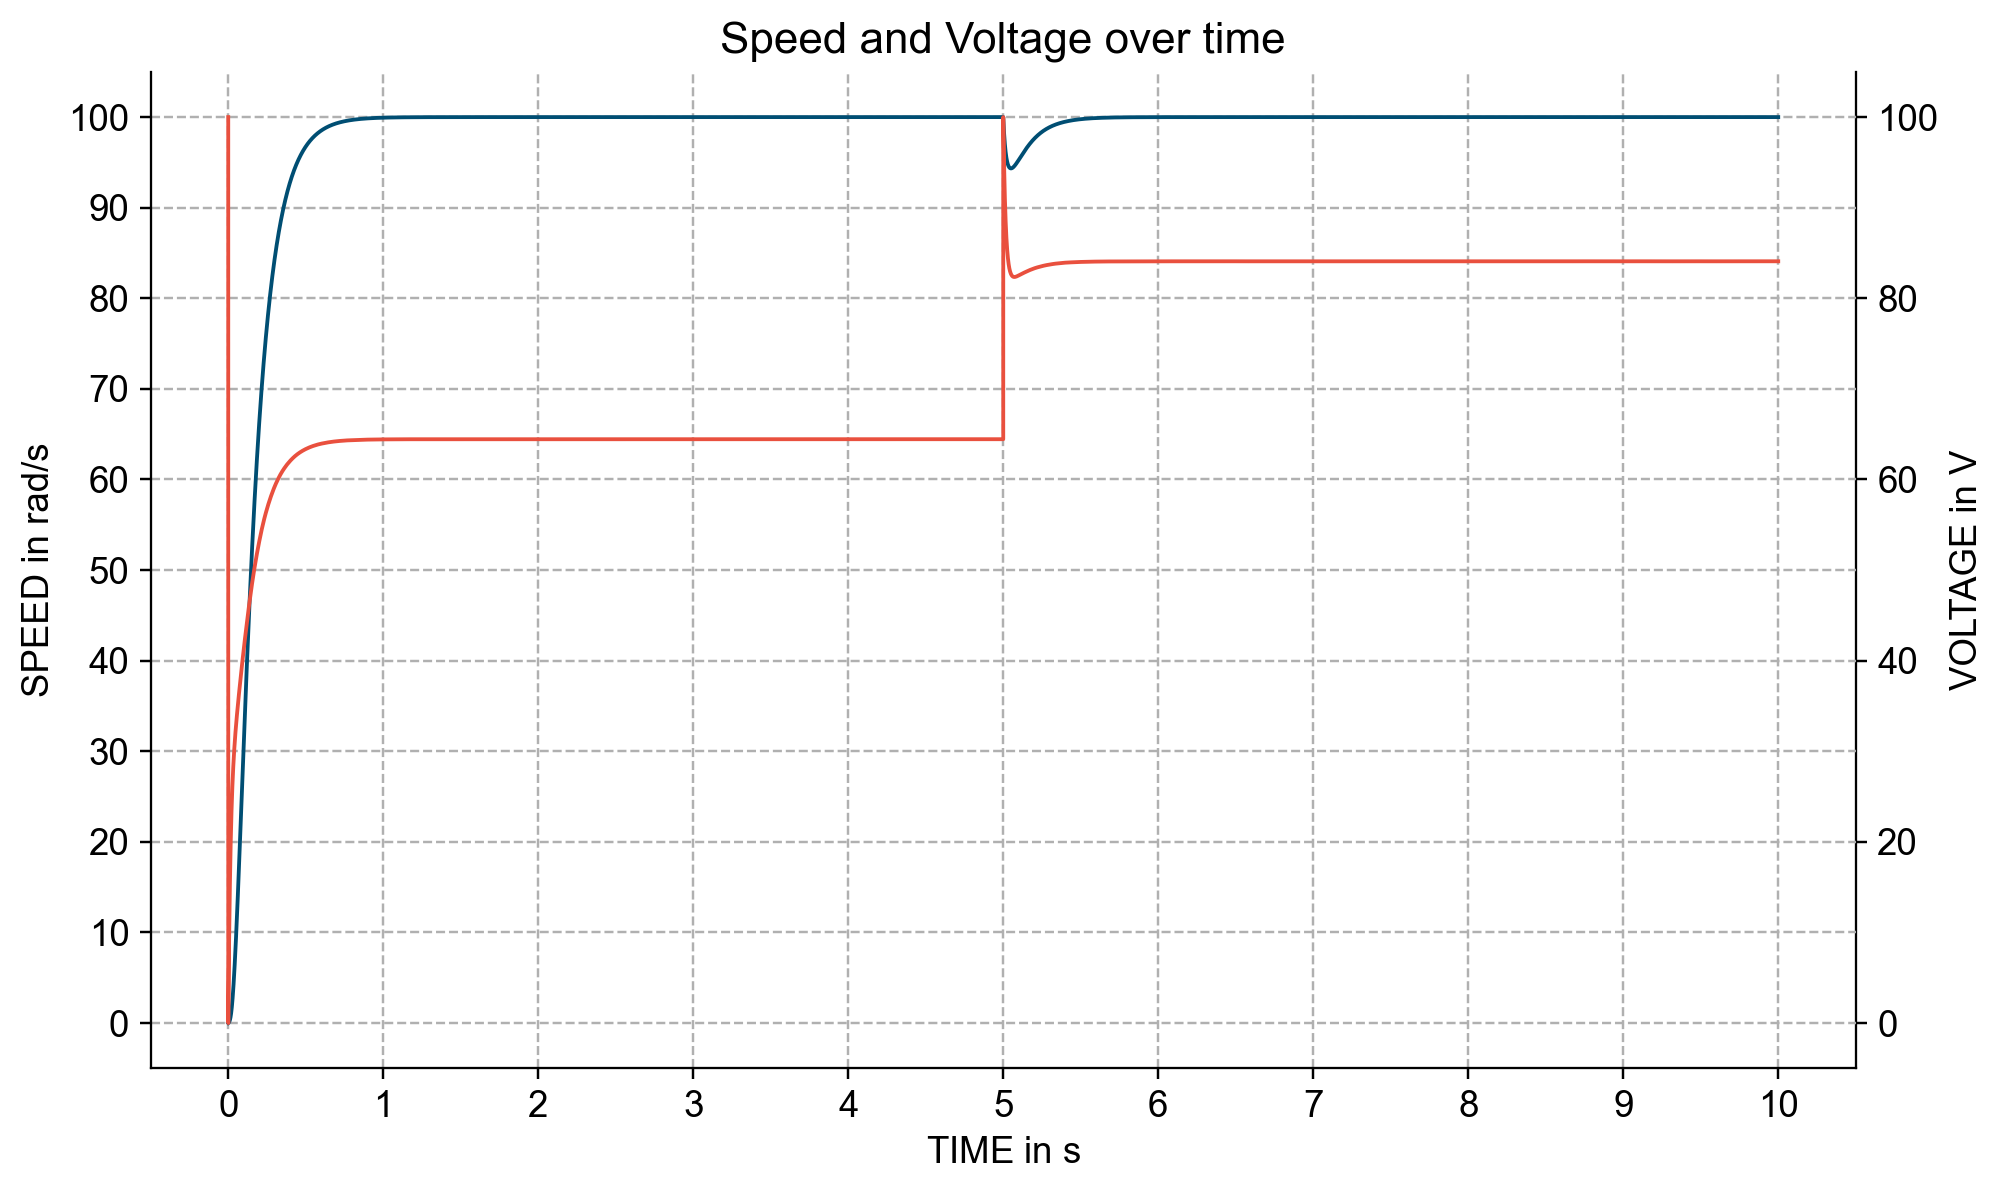

In [23]:
from plot import plot_results
style_sheet_path = os.path.join(os.path.realpath('..'), "FST.mplstyle")
speed_unit = units["DC_Motor.y"]
y = [results["DC_Motor.y"], results["pid.u"]]
x = results["time"]
ax = plot_results(y,x, y_label= f"SPEED in {speed_unit}" ,x_label=r'TIME in $s$' , title = "Speed and Voltage over time", style_sheet_path= style_sheet_path, figsize = (10,6))
ax.set_xticks([i for i in range(11)])
ax.set_yticks([10*i for i in range(11)])
ax.grid(linestyle = "--")
sec_ax = ax.secondary_yaxis("right")
sec_ax.set_ylabel("VOLTAGE in V")

Next the results can be stored in a hdf5 file. 

In [24]:
from store_data import Project, store_data, read_data
working_directory = os.path.join(os.path.realpath('.'), "motor_example_1")
project = Project(working_directory)
# create a new run 
folders_in_run = ["simulation_results"]
attr = {"simulation_results": {"step size": 0.0001}}
project.create_run(folders_in_run, attr= attr, create_run_folder = False)

Using existing hdf5 'hdf5_210906_150009.hdf5'
Run_4 created


The results of the simulation can be stored in a hdf5 file.

In [25]:
variable_list = list(results.columns)
hdf5_path = project.hdf5_path
current_run_folder = project.current_run_name
sub_folder_name = "simulation_results"
hdf5_folder_name = project.current_run_name + "/" + sub_folder_name
for var in variable_list:
    if var != "time":
        time_series = results[["time", var]].to_records(index= False)
        data_name = var
        if units.get(var): # add the unit (if known) of the variable as a attribute 
            attr = {"unit": units[var]}
        else:
            attr = None
        store_data(hdf5_path, time_series,data_name ,hdf5_folder_name, attr)

The data can also be read from the hdf5 file.

In [26]:
from store_data import read_data

# list the folders in a hdf5 group, to get the attribute of the folder 'Run_1' set get_attrbute = True
data_name = "Run_1"
data, attr = read_data(hdf5_path, data_name,get_attribute= True)
print(data, attr)

['simulation_results'] {'creation date': 'Monday, 06. September 2021, 15:00:09'}


In [28]:
# get a dataset
data_name = "Run_1/simulation_results/DC_Motor.y"
data = read_data(hdf5_path, data_name, False)
# convert back to pandas Dataframe
import pandas as pd
data = pd.DataFrame(data)
data

,time,DC_Motor.y
0,0.0000,0.000000
1,0.0001,0.000326
2,0.0002,0.001302
3,0.0003,0.002850
4,0.0004,0.004478
...,...,...
99996,9.9996,99.999980
99997,9.9997,99.999978
99998,9.9998,99.999976
99999,9.9999,99.999974
